# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.744057,True,5.559694
1,-0.198492,True,3.202457
2,-0.038446,True,4.695087
3,0.336731,True,6.167892
4,-1.002073,False,-1.232013
...,...,...,...
995,-0.003614,True,5.402220
996,0.377980,False,0.698121
997,0.709293,True,4.429458
998,0.154723,False,1.398045


<AxesSubplot: xlabel='v0'>

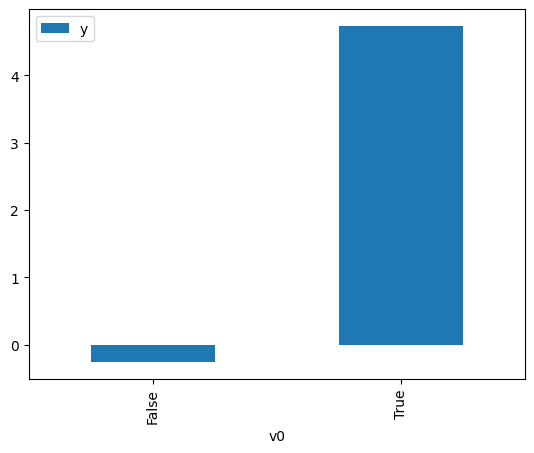

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

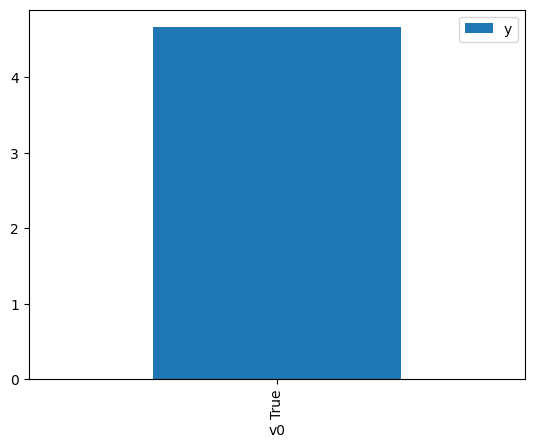

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.210913,False,0.478034,0.794206,1.259120
1,-0.413131,False,-0.609083,0.590549,1.693341
2,-0.681177,False,-0.348365,0.667506,1.498115
3,-0.608580,False,-3.121269,0.647339,1.544786
4,0.002878,False,0.020567,0.463316,2.158355
...,...,...,...,...,...
995,0.440501,False,-0.244749,0.334723,2.987546
996,0.024040,False,2.203712,0.456831,2.188995
997,0.295594,False,-0.272972,0.375633,2.662176
998,0.619412,False,-0.768564,0.287486,3.478431


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.005606,True,5.232703,0.534081,1.872377
1,-0.491897,True,4.617018,0.386178,2.589482
2,0.716247,True,7.484314,0.736352,1.358047
3,-0.146622,True,5.384826,0.490642,2.038148
4,-1.491504,True,2.370634,0.154906,6.455547
...,...,...,...,...,...
995,0.169870,True,4.474222,0.587350,1.702563
996,-0.064628,True,4.153035,0.515924,1.938270
997,0.567429,True,5.934870,0.699200,1.430205
998,-0.077432,True,5.474245,0.511978,1.953208


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                              6110.
Date:                Fri, 11 Nov 2022   Prob (F-statistic):                        0.00
Time:                        08:02:04   Log-Likelihood:                         -1409.5
No. Observations:                1000   AIC:                                      2823.
Df Residuals:                     998   BIC:                                      2833.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5847      0.030     19.808      0.000       0.527       0.643
x2             4.9646      0.047    105.150      0.000       4.872       5.057
==============================================================================
Omnibus:                        0.208   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.901   Jarque-Bera (JB):                0.291
Skew:                          -0.009   Prob(JB):                        0.864
Kurtosis:                       2.918   Cond. No.                         1.63
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""